<a href="https://colab.research.google.com/github/natrixbasil/ML_Homeworks/blob/main/homework3_logreg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Импорт модулей

In [2]:
import numpy as np
import pandas as pd
from google.colab import files

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

import seaborn as sns; sns.set()

from sklearn.datasets import make_moons, make_circles, make_classification

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate

from sklearn.metrics import accuracy_score as acc
from sklearn.metrics import f1_score as f1
import sklearn.metrics

# Необходимые функции

Для графиков

In [3]:
def plot_data(ax,ds,name='',marker = 'o',colors =("#FF0000", '#0000FF'),alpha=0.7, s = 150, facecolor=True):
    X, y = ds

    cm_bright = ListedColormap(colors)
    ax.set_title(name, fontsize = 30)
    if facecolor:
        ax.scatter(X[:, 0], X[:, 1],
                   marker = marker, c=y,
                   cmap=cm_bright,s = s,
                   alpha =alpha)
    else:
        ax.scatter(X[:, 0], X[:, 1],
                   marker = marker, c=y,
                   cmap=cm_bright,s = s,
                   facecolor = 'None',
                   alpha =alpha)

    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    ax.grid(True)
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xticks(())
    ax.set_yticks(())

Генерация данных

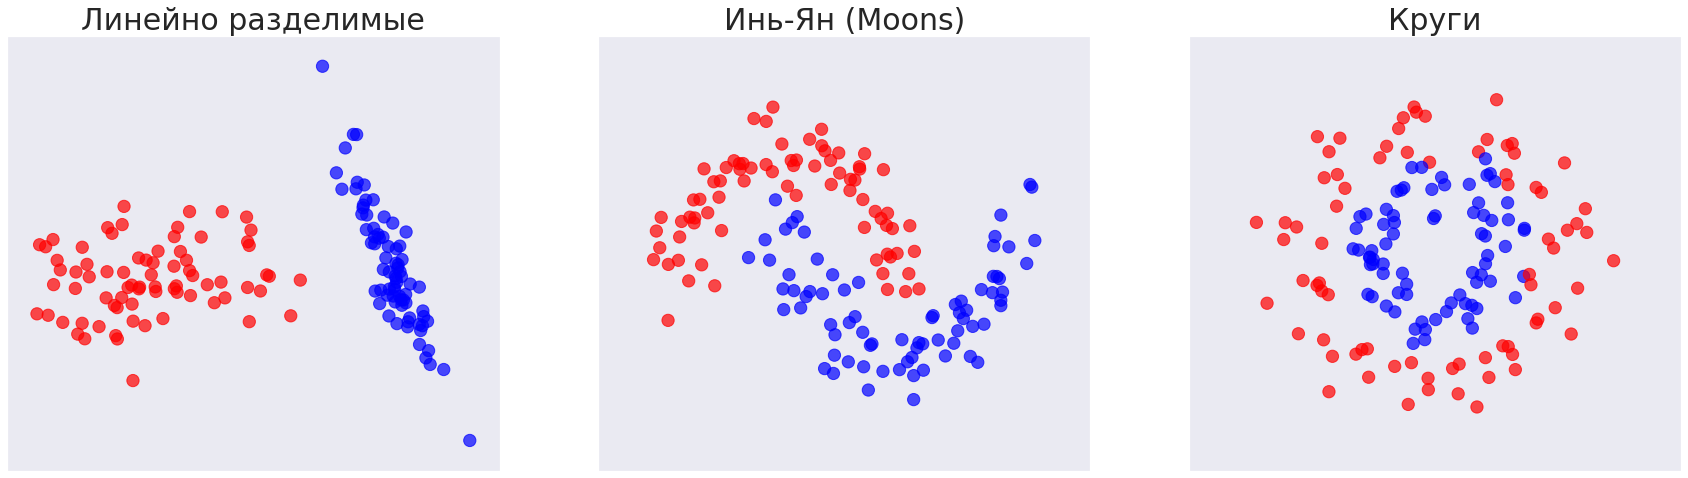

In [4]:
N = 150 #@param {type:"slider", min:50, max:250, step:25}


def make_binary_clf(N, method = 'line',
                    noises = 0.15,
                    random_state = 42):

    if random_state: rng = np.random.RandomState(seed = random_state)
    
    if method == 'line' or method is None:
        X, y = make_classification(n_samples=N, n_features=2,
                                   n_redundant=0, n_informative=2,
                                   n_clusters_per_class=1, class_sep=2,
                                   random_state=random_state)
        X += np.random.randn(*X.shape) *noises
        out = (X, y)
    
    elif method == 'moons':
        X, y = make_moons(n_samples=N, noise=noises, 
                          random_state=random_state)
    
    elif method == 'circles':    
        X, y = make_circles(n_samples=N, noise=noises, factor=0.5,
                            random_state=random_state )

    
    return X,y


fig=plt.figure(figsize=(30,8))

ax = plt.subplot(1, 3, 1)
plot_data(ax,make_binary_clf(N,method = 'line'),
          'Линейно разделимые')
ax = plt.subplot(1, 3, 2)
plot_data(ax,make_binary_clf(N,method = 'moons'), 
          'Инь-Ян (Moons)')
ax = plt.subplot(1, 3, 3)
plot_data(ax, make_binary_clf(N,method = 'circles'),
          'Круги')

Линейная регрессия

In [5]:
class LinearRegression():
    def __init__(self, 
                 learning_rate = 0.5, 
                 epochs = 100, 
                 weights = None, 
                 bias    = None, 
                 batch_size   = 1000,
                 n_batches    = None,
                 random_state = 42):
        self.lr      = learning_rate
        self.epochs  = epochs
        self.weights = weights
        self.bias    = bias
        self.seed    = random_state
        self.batch_size = batch_size
        self.cost    = np.zeros(epochs)
        
        self.n_batches = n_batches
        
        if not(self.weights is None) and (self.bias):
            if self.weights.size == X.shape[1]:
                self.weights = np.append(self.bias,self.weights)
    
    #---------------------------------
    def forward(self, X):
        return np.dot(X, self.weights)
    
    #---------------------------------
    def loss(self,yhat, y):
        return np.square(yhat - y).sum()/y.size
    
    #---------------------------------
    def grad_step(self,yhat, y, X):
        return 2*np.dot(X.T, (yhat - y)) / y.size
    
    #---------------------------------
    def update(self):    
        return self.weights - self.lr*self.grad
    
    #---------------------------------
    def init(self, weights_size):
        np.random.seed(self.seed)
        return np.random.randn(weights_size)/np.sqrt(weights_size)
    
    #---------------------------------
    def predict(self, X):
        yhat = self.forward(self.add_bias(X))
        return yhat.squeeze()
    
    #---------------------------------
    def score(self, X, y):        
        yhat = self.predict(X)
        return 1-np.sum(np.square(y-yhat))/np.sum(np.square(y-np.mean(y)))
    
    #---------------------------------
    def fit(self, X, y):

        np.random.seed(self.seed)

        if self.weights is None:
            self.weights = self.init(X.shape[1])
        
        if self.bias is None: 
            self.bias    = self.init(1)
        
        if self.weights.size == X.shape[1]:
            self.weights = np.append(self.bias,self.weights)
        
        self.grad    = np.zeros(self.weights.shape)
        self.cost    = np.zeros(self.epochs)

        if self.batch_size is None:            
            self.batch_size = y.size
            
        if self.n_batches is None:
            self.n_batches = y.size//self.batch_size
            
        for i in range(self.epochs): 
            loss = 0
            for cnt,(x_batch, y_batch) in enumerate(self.load_batch(X,y)): 

                yhat         = self.forward(x_batch)
                self.grad    = self.grad_step(yhat,  y_batch, x_batch) 
                self.weights = self.update() 
                loss += self.loss(yhat,  y_batch)
                
                if cnt>= self.n_batches:
                    break
            self.cost[i] = loss/self.n_batches
        
        self.bias = self.weights[0]
    #---------------------------------
    def load_batch(self,X,y):
        idxs = np.arange(y.size)
        np.random.shuffle(idxs)

        for i_batch in range(0,y.size,self.batch_size):
            idx_batch = idxs[i_batch:i_batch+self.batch_size]
            x_batch   = np.take(X, idx_batch,axis=0)
            x_batch   = self.add_bias(x_batch)
            y_batch   = np.take(y, idx_batch)
            yield  x_batch, y_batch
    
    #---------------------------------
    def add_bias(self, X):
        return np.column_stack((np.ones(X.shape[0]), X))
    
    #---------------------------------
    def plot_cost(self, figsize = (12,6), title = ''):
        plt.figure(figsize = figsize)
        plt.plot(self.cost)
        plt.grid()
        plt.xlabel('Эпоха', fontsize = 24)
        plt.ylabel('Функция Потерь', fontsize = 24)
        plt.title(title, fontsize = 24)
        plt.show()
    
    #---------------------------------
    def get_w_and_b(self):
        return (self.weights[1:], self.bias)

Эластичная регрессия

In [6]:
class ElasticRegression(LinearRegression):
    def __init__(self, 
                 learning_rate = 0.5,
                 l1_penalty = 0.0,
                 l2_penalty = 0.0,
                 epochs = 100, 
                 weights = None, 
                 bias    = None, 
                 batch_size   = 1000, 
                 n_batches    = None,
                 random_state = 42):
        
        super().__init__(learning_rate = learning_rate,
                         epochs = epochs, 
                         weights = weights, 
                         bias    = bias, 
                         batch_size   = batch_size, 
                         n_batches    = n_batches,
                         random_state = random_state)
        self.l1_penalty = l1_penalty
        self.l2_penalty = l2_penalty
        
    #---------------------------------
    def loss(self,yhat, y):   
        l1_term = self.l1_penalty*np.sum(self.weights[1:])/y.size
        l2_term = (self.l2_penalty/2)*np.sum(np.square(self.weights[1:]))/y.size
        return np.square(yhat - y).mean() + l1_term + l2_term
                  
    #---------------------------------
    def update(self):    
        l2_term = self.l2_penalty*np.sum(self.weights[1:])
        return self.weights - self.lr*(self.grad + np.sign(self.weights)*self.l1_penalty  + l2_term)

Логистическая регрессия

In [7]:
_EPS_ = 1e-6

class LogisticRegression(ElasticRegression):
    def __init__(self, 
                 learning_rate = 0.5,
                 l1_penalty    = 0.0,
                 l2_penalty    = 0.0,
                 epochs        = 100, 
                 weights       = None, 
                 bias          = None, 
                 threshold     = 0.5,
                 batch_size    = 1000, 
                 n_batches     = None,
                 random_state  = 42):
        
        super().__init__(learning_rate = learning_rate,
                         epochs = epochs, 
                         weights = weights, 
                         bias    = bias, 
                         batch_size   = batch_size, 
                         n_batches    = n_batches,
                         random_state = random_state,
                         l1_penalty = l1_penalty,
                         l2_penalty = l2_penalty)       
        self.learning_rate = learning_rate/2
        self.threshold = threshold
    #---------------------------------    
    def loss(self,yhat, y):
        
        l1_term = self.l1_penalty*np.sum(self.weights[1:])
        l2_term = (self.l2_penalty/2)*np.sum(np.square(self.weights[1:]))
        
        return -(y*np.log(yhat  + _EPS_)+(1 - y)*np.log(1 - yhat  + _EPS_)).mean()\
            + l1_term+ l2_term   
    #---------------------------------
    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))     
    #---------------------------------
    def forward(self, X):     
        return self.sigmoid(np.dot(X, self.weights))   
    #---------------------------------
    def to_class(self,logit):
        return (logit>=self.threshold)*1   
    #---------------------------------
    def predict(self, X):
        yhat = self.forward(self.add_bias(X))
        return self.to_class(yhat)

    #---------------------------------
    def predict_prob(self, X):
        yhat = self.forward(self.add_bias(X))
        return yhat 
    #---------------------------------
    def score(self, X, y):
        yhat  = self.predict(X)
        return sum((yhat==y)*1)/y.size
    #---------------------------------
    def plot_desicion_function(self,X,y,figsize = (12,6),
                               marker = 'o',colors =("#FF0000", '#0000FF'),
                               alpha=0.7, s = 150, poly = False, order = 2):
        plt.figure(figsize = figsize)
        cm_bright = ListedColormap(colors)
        plt.scatter(X[:, 0], X[:, 1],marker = marker, c=y, cmap=cm_bright,s = s, alpha =alpha);
        h =  (X[:, 0].max() - X[:, 0].min())/50
        x_min, x_max = X[:, 0].min()-0.5 , X[:, 0].max()+0.5
        y_min, y_max = X[:, 1].min()-0.5 , X[:, 1].max()+0.5    
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                            np.arange(y_min, y_max, h))
        if poly:
            Z = self.predict_prob(to_polynom(np.c_[xx.ravel(), yy.ravel()],order))-0.5
        else:
            Z = self.predict_prob(np.c_[xx.ravel(), yy.ravel()])-0.5
        cm = plt.cm.RdBu
        Z = Z.reshape(xx.shape) 
        plt.contourf(xx, yy, Z, cmap=cm, alpha=.5)
        plt.xticks([],[])
        plt.yticks([],[])
        plt.tight_layout()
    #---------------------------------
    def classification_report(self, X,y):
        tp = 0 # true_positives
        tn = 0 # true_negatives
        fp = 0 # false_positives
        fn = 0 # false_negatives
        
        yhat  = self.predict(X)
        total = yhat.size
        n= sum(yhat==0)
        p = sum(yhat==1)
        
        for yhati,yi in zip(yhat,y):
            if yi == 1 and yhati == 1:
                tp += 1
            elif yi == 0 and yhati == 0:
                tn += 1
            elif yi == 1 and yhati == 0:
                fn += 1
            elif yi == 0 and yhati == 1:
                fp += 1

        print('True Positives:%.4f'%(tp/p), end = '\t')
        print('True Negatives:%.4f'%(tn/n))
        print('False Positives:%.4f'%(fp/p), end = '\t')
        print('False Negatives:%.4f'%(fn/n))
        print('Accuracy:%.4f'% ((tp + tn) / total))
        print('Recall:%.4f'% (tp / (tp + fn)), end = '\t')
        print('Precision:%.4f'%(tp / (tp + fp)))
        print('f1 measure:%.4f'%(tp / (tp + 0.5*(fp+fn))))

# Круги

Генерируем данные

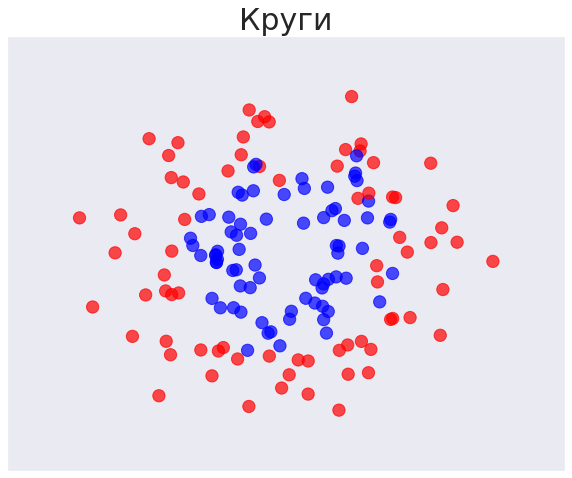

In [8]:
X,y = make_binary_clf(N,method = 'circles', noises=0.20)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

fig = plt.figure(figsize= (10,8))
ax = plt.subplot(1, 1, 1)
plot_data(ax,(X,y),
          'Круги')

Создаём полиномы

In [9]:
def to_polynom(X, order = 2):
    order_range = range(order, order+1,1)
    out = np.copy(X) 
    for i in order_range:
        out = np.hstack([out, np.power(X,i)])
    return out

In [10]:
X_poly   = to_polynom(X, order = 2)

X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.3, random_state=42)

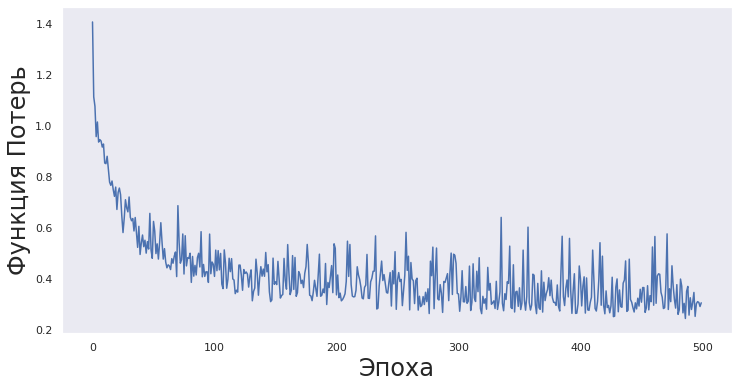

0.8888888888888888 0.9047619047619048
True Positives:0.9048	True Negatives:0.8750
False Positives:0.0952	False Negatives:0.1250
Accuracy:0.8889
Recall:0.8636	Precision:0.9048
f1 measure:0.8837


In [11]:
regr = LogisticRegression(learning_rate=0.25,
                          epochs=500,batch_size=50,
                          )

regr.fit(X_train, y_train)

regr.plot_cost()

print(regr.score(X_test, y_test), regr.score(X_train, y_train))

regr.classification_report(X_test, y_test)

Рисуем график

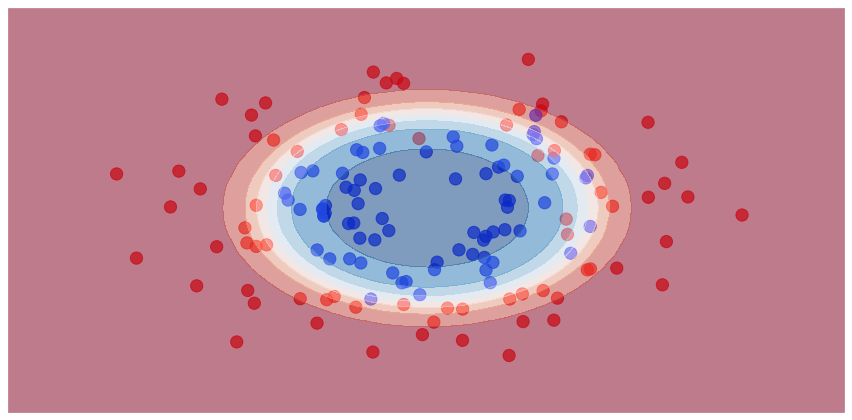

In [12]:
regr.plot_desicion_function(X_poly,y,
                            poly = True, order = 2)

# Круги: улучшение результата

Увеличение степени полинома

In [13]:
X_poly   = to_polynom(X, order = 4)

X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.3, random_state=42)

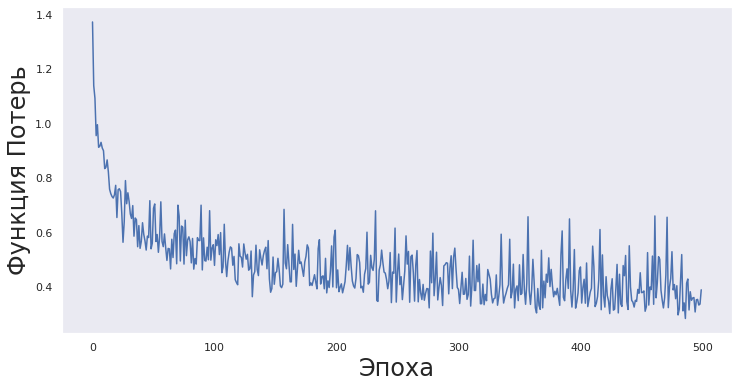

0.8888888888888888 0.8952380952380953
True Positives:0.8696	True Negatives:0.9091
False Positives:0.1304	False Negatives:0.0909
Accuracy:0.8889
Recall:0.9091	Precision:0.8696
f1 measure:0.8889


In [14]:
regr = LogisticRegression(learning_rate=0.25,
                          epochs=500,batch_size=50,
                          )

regr.fit(X_train, y_train)

regr.plot_cost()

print(regr.score(X_test, y_test), regr.score(X_train, y_train))

regr.classification_report(X_test, y_test)

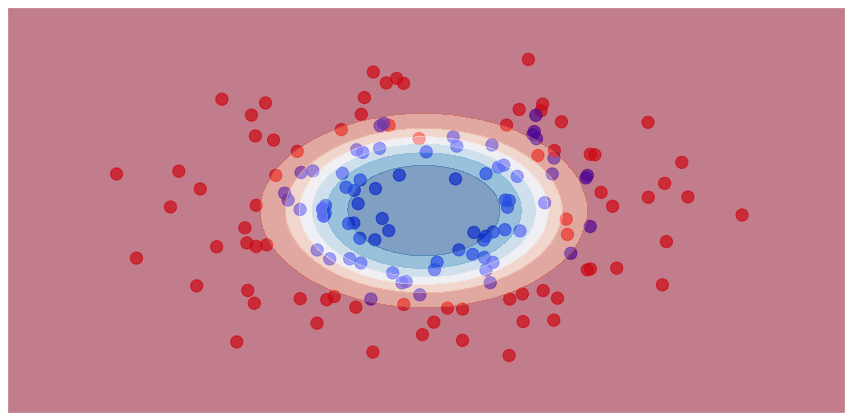

In [15]:
regr.plot_desicion_function(X_poly,y,
                            poly = True, order = 2)

Включаем регуляризацию

In [16]:
X_poly   = to_polynom(X, order = 2)

X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.3, random_state=42)

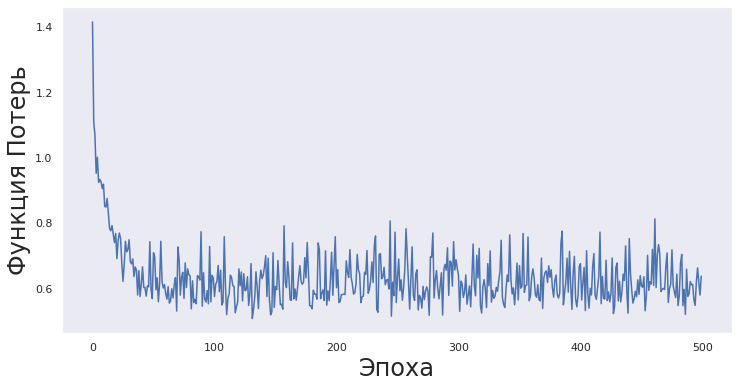

0.9111111111111111 0.8666666666666667
True Positives:0.8462	True Negatives:1.0000
False Positives:0.1538	False Negatives:0.0000
Accuracy:0.9111
Recall:1.0000	Precision:0.8462
f1 measure:0.9167


In [17]:
regr = LogisticRegression(learning_rate=0.25,
                          epochs=500,batch_size=50, l1_penalty=0.01, l2_penalty=0.01
                          )

regr.fit(X_train, y_train)

regr.plot_cost()

print(regr.score(X_test, y_test), regr.score(X_train, y_train))

regr.classification_report(X_test, y_test)

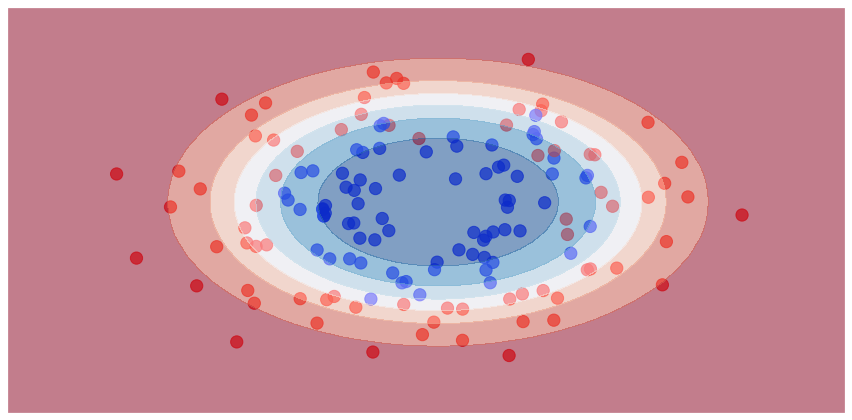

In [18]:
regr.plot_desicion_function(X_poly,y,
                            poly = True, order = 2)

# Луны

Генерируем данные

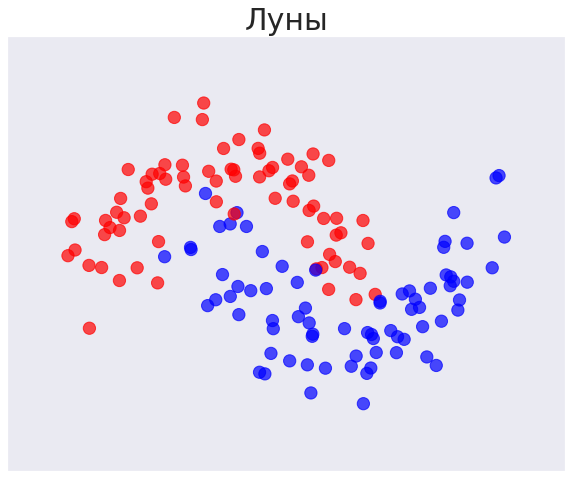

In [19]:
X,y = make_binary_clf(N,method = 'moons', noises=0.20)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

fig = plt.figure(figsize= (10,8))
ax = plt.subplot(1, 1, 1)
plot_data(ax,(X,y),
          'Луны')

Создаём полиномы

In [20]:
def to_polynom(X, order = 2):
    order_range = range(order, order+1,1)
    out = np.copy(X) 
    for i in order_range:
        out = np.hstack([out, np.power(X,i)])
    return out

In [21]:
X_poly   = to_polynom(X, order = 2)

X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.3, random_state=42)


Проводим регрессию

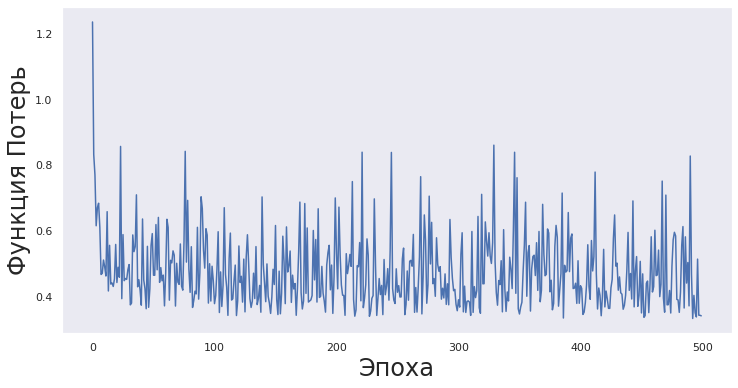

0.8444444444444444 0.8666666666666667
True Positives:0.8947	True Negatives:0.8077
False Positives:0.1053	False Negatives:0.1923
Accuracy:0.8444
Recall:0.7727	Precision:0.8947
f1 measure:0.8293


In [22]:
regr = LogisticRegression(learning_rate=0.25,
                          epochs=500,batch_size=50,
                          )

regr.fit(X_train, y_train)

regr.plot_cost()

print(regr.score(X_test, y_test), regr.score(X_train, y_train))

regr.classification_report(X_test, y_test)

Рисуем график

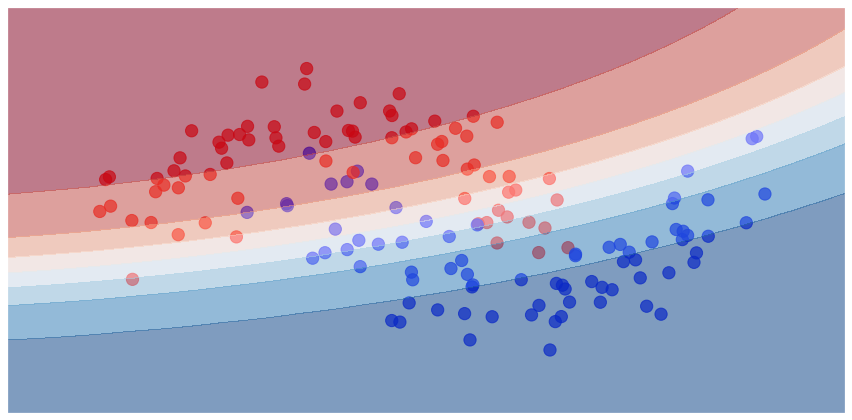

In [23]:
regr.plot_desicion_function(X_poly,y,
                            poly = True, order = 2)

# Луны: улучшение результата

Делаем полином с бОльшей степенью

In [24]:
X_poly   = to_polynom(X, order = 5)

X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.3, random_state=42)

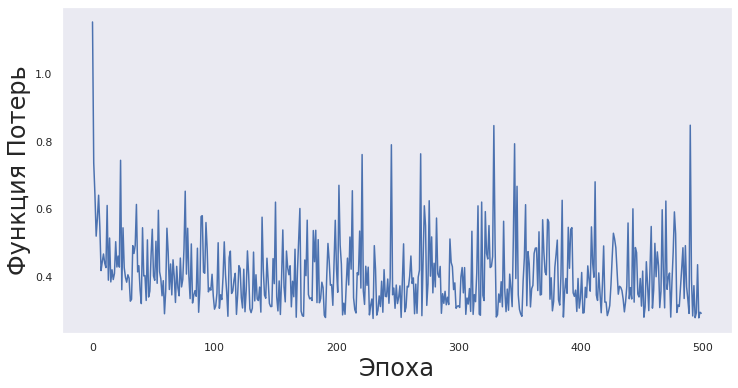

0.8444444444444444 0.8761904761904762
True Positives:0.8947	True Negatives:0.8077
False Positives:0.1053	False Negatives:0.1923
Accuracy:0.8444
Recall:0.7727	Precision:0.8947
f1 measure:0.8293


In [25]:
regr = LogisticRegression(learning_rate=0.25,
                          epochs=500,batch_size=50,
                          )

regr.fit(X_train, y_train)

regr.plot_cost()

print(regr.score(X_test, y_test), regr.score(X_train, y_train))

regr.classification_report(X_test, y_test)

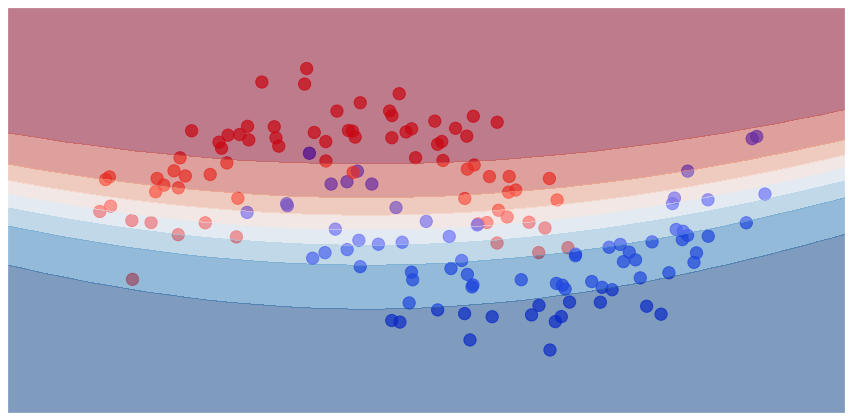

In [26]:
regr.plot_desicion_function(X_poly,y,
                            poly = True, order = 2)

In [27]:
X_poly   = to_polynom(X, order = 6)

X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.3, random_state=42)

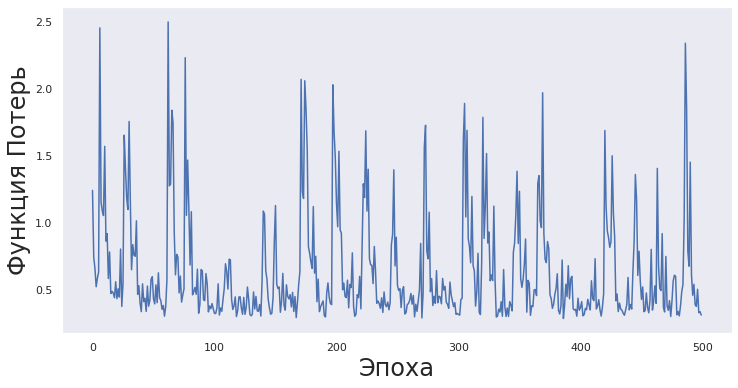

0.8444444444444444 0.8857142857142857
True Positives:0.9412	True Negatives:0.7857
False Positives:0.0588	False Negatives:0.2143
Accuracy:0.8444
Recall:0.7273	Precision:0.9412
f1 measure:0.8205


In [28]:
regr = LogisticRegression(learning_rate=0.25,
                          epochs=500,batch_size=50,
                          )

regr.fit(X_train, y_train)

regr.plot_cost()

print(regr.score(X_test, y_test), regr.score(X_train, y_train))

regr.classification_report(X_test, y_test)

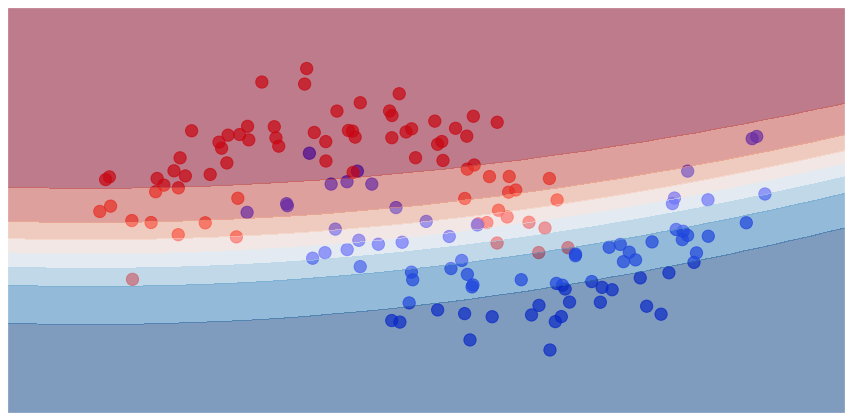

In [29]:
regr.plot_desicion_function(X_poly,y,
                            poly = True, order = 2)

Включаем регуляризацию

In [30]:
X_poly   = to_polynom(X, order = 5)

X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.3, random_state=42)

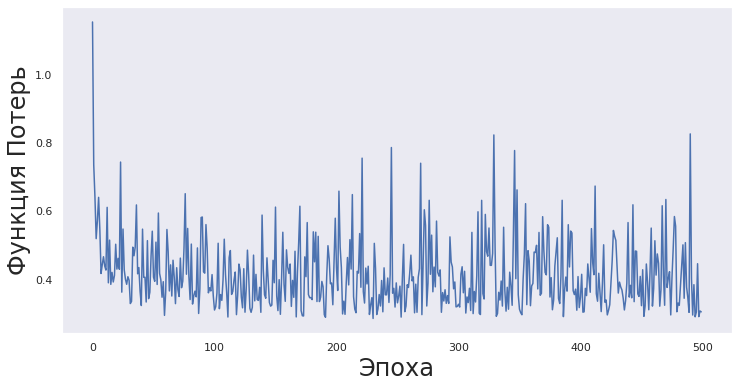

0.8444444444444444 0.8761904761904762
True Positives:0.8947	True Negatives:0.8077
False Positives:0.1053	False Negatives:0.1923
Accuracy:0.8444
Recall:0.7727	Precision:0.8947
f1 measure:0.8293


In [31]:
regr = LogisticRegression(learning_rate=0.25,
                          epochs=500,batch_size=50, l1_penalty=0.001, l2_penalty=0.001
                          )

regr.fit(X_train, y_train)

regr.plot_cost()

print(regr.score(X_test, y_test), regr.score(X_train, y_train))

regr.classification_report(X_test, y_test)

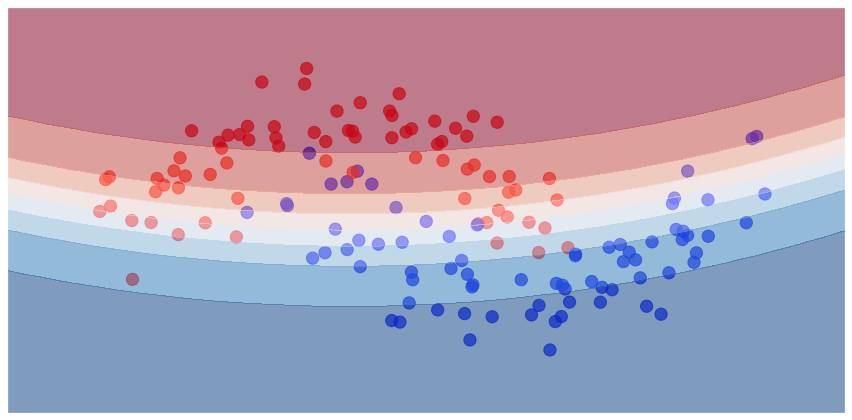

In [32]:
regr.plot_desicion_function(X_poly,y,
                            poly = True, order = 2)

# Выводы

**Увеличение степени полинома для кругов**

Максимальная степень, при которой результаты классификации улучшаются, а не становятся хуже - четвёртая.

**Увеличение степени полинома для лун**

Максимальная степень, при которой результаты классификации не становятся хуже - пятая. При этом они не улучшаются или улучшаются, но незначительно. Видимо, дефолтная вторая степень оптимальна для этой модели.

**Регуляризация**

Поскольку класс логистической регрессии построен на классе эластичной регрессии, туда уже включены l1 и l2 регуляризации. Единственное что надо сделать - указать коэффициенты штрафов.

Для кругов результат стал заметно лучше, а также уменьшились значения функции потерь. Для лун - только уменьшились потери.

# Cars_Moldova

Загрузка данных

In [33]:
uploaded = files.upload()

Saving cars_moldova_norm.csv to cars_moldova_norm.csv


In [34]:
df = pd.read_csv('/content/cars_moldova_norm.csv', delimiter = ',')
df

,Make,Model,Year,Style,Distance,Engine_capacity(cm3),Fuel_type,Transmission,Price(euro),Age,km_year,mileage
0,Toyota,Prius,2011,Hatchback,195000.0,1800.0,Hybrid,Automatic,7750.0,11,17727.272727,medium
1,Renault,Grand Scenic,2014,Universal,135000.0,1500.0,Diesel,Manual,8550.0,8,16875.000000,medium
2,Renault,Laguna,2012,Universal,110000.0,1500.0,Diesel,Manual,6550.0,10,11000.000000,medium
3,Opel,Astra,2006,Universal,200000.0,1600.0,Metan/Propan,Manual,4100.0,16,12500.000000,medium
4,Mercedes,Vito,2000,Microvan,300000.0,2200.0,Diesel,Manual,3490.0,22,13636.363636,medium
...,...,...,...,...,...,...,...,...,...,...,...,...
32215,Volkswagen,Passat,2016,Sedan,88000.0,1800.0,Petrol,Automatic,11500.0,6,14666.666667,medium
32216,Land Rover,Freelander,2002,Crossover,225000.0,1800.0,Metan/Propan,Manual,4400.0,20,11250.000000,medium
32217,Dacia,Logan Mcv,2015,Universal,89000.0,1500.0,Diesel,Manual,7000.0,7,12714.285714,medium
32218,Mazda,6,2006,Combi,370000.0,2000.0,Diesel,Manual,4000.0,16,23125.000000,medium


Категориальные и числовые колонки

In [35]:
cat_columns = ['Make', 'Model', 'Style', 'Fuel_type', 'Transmission', 'mileage'] 
num_columns = ['Year', 'Distance', 'Engine_capacity(cm3)', 'Price(euro)', 'km_year']

Кодируем категориальные данные

In [36]:
df[cat_columns] = df[cat_columns].astype('category')

for _, column_name in enumerate(cat_columns):
    df[column_name] =  df[column_name].cat.codes
df.head()

,Make,Model,Year,Style,Distance,Engine_capacity(cm3),Fuel_type,Transmission,Price(euro),Age,km_year,mileage
0,42,92,2011,4,195000.0,1800.0,2,0,7750.0,11,17727.272727,1
1,34,62,2014,11,135000.0,1500.0,0,1,8550.0,8,16875.000000,1
2,34,71,2012,11,110000.0,1500.0,0,1,6550.0,10,11000.000000,1
3,28,23,2006,11,200000.0,1600.0,3,1,4100.0,16,12500.000000,1
4,23,126,2000,5,300000.0,2200.0,0,1,3490.0,22,13636.363636,1


# Классы регрессий

In [78]:
class LinearRegression():
    def __init__(self, 
                 learning_rate = 0.5, 
                 epochs = 100, 
                 weights = None, 
                 bias    = None, 
                 batch_size   = 1000, 
                 random_state = 42):
        self.lr      = learning_rate
        self.epochs  = epochs
        self.weights = weights
        self.bias    = bias
        self.seed    = random_state
        self.batch_size = batch_size
        self.cost    = np.zeros(epochs)
        
        # если веса и смещения заданы
        if not(self.weights is None) and (self.bias):
            if self.weights.size == X.shape[1]:
            #совмещаем в один массив, если мы этого не сделали
                self.weights = np.append(self.bias,self.weights)
    
    #---------------------------------
    def forward(self, X):
        return self.weights.dot(X.T)
    
    #---------------------------------
    def loss(self,yhat, y):
        return np.square(yhat - y).sum()/y.size
    
    #---------------------------------
    def grad_step(self,yhat, y, X):
        return 2*np.dot(X.T, (yhat - y)) / y.size
    
    #---------------------------------
    def update(self):    
        return self.weights - self.lr*self.grad
    
    #---------------------------------
    def init(self, weights_size):
        np.random.seed(self.seed)
        return np.random.randn(weights_size)/np.sqrt(weights_size)
    
    #---------------------------------
    def add_bias(self, X):
        return np.column_stack((np.ones(X.shape[0]), X))

    #---------------------------------
    def predict(self, X):
        yhat = self.forward(self.add_bias(X))
        return yhat
    
    #---------------------------------
    def score(self, X, y):        
        yhat = self.predict(X)
        return 1-np.sum(np.square(y-yhat))/np.sum(np.square(y-np.mean(y)))

     #---------------------------------
    def load_batch(self,X,y):
        idx_batch = np.random.randint(0,X.shape[0],self.batch_size)
        x_batch   = np.take(X, idx_batch, axis=0)
        x_batch   = self.add_bias(x_batch)
        y_batch   = np.take(y, idx_batch)
        return  x_batch, y_batch

    #---------------------------------
    def fit(self, X, y):

        np.random.seed(self.seed)
        
        if self.weights is None:
            self.weights = self.init(X.shape[1])
        
        if self.bias is None: 
            self.bias    = self.init(1)
        
        if self.weights.size == X.shape[1]:
            #совмещаем в один массив, если мы этого не сделали
            self.weights = np.append(self.bias,self.weights)
        
        self.grad    = np.zeros(self.weights.shape)
        self.cost    = np.zeros(self.epochs)

        if self.batch_size is None:            
            x_batch   = self.add_bias(X)
            y_batch   = y
        
        for i in range(self.epochs): 

            if self.batch_size: 
                x_batch, y_batch = self.load_batch(X,y)

            yhat         = self.forward(x_batch)
            self.grad    = self.grad_step(yhat,  y_batch, x_batch) 
            self.weights = self.update()  
            self.cost[i] = self.loss(yhat,  y_batch)

        self.bias = self.weights[0]
     
    #---------------------------------
    def plot_cost(self, figsize = (12,6)):
        plt.figure(figsize = figsize)
        plt.plot(self.cost,'-*')
        plt.show()
    
    #---------------------------------
    def get_w_and_b(self):
        return (self.weights[1:], self.bias)

In [79]:
class ElasticRegression(LinearRegression):
    def __init__(self, 
                 learning_rate = 0.5,
                 l1_penalty = 0.001,
                 l2_penalty = 0.001,
                 epochs = 100, 
                 weights = None, 
                 bias    = None, 
                 batch_size   = 1000, 
                 random_state = 42):
        
        super().__init__(learning_rate = learning_rate,
                         epochs = epochs, 
                         weights = weights, 
                         bias    = bias, 
                         batch_size   = batch_size, 
                         random_state = random_state)
        self.l1_penalty = l1_penalty
        self.l2_penalty = l2_penalty
    #---------------------------------
    def loss(self,yhat, y):   
        l1_term = self.l1_penalty*np.sum(self.weights[1:])/y.size
        l2_term = (self.l2_penalty/2)*np.sum(np.square(self.weights[1:]))/y.size
        return np.square(yhat - y).mean() + l1_term + l2_term
                  
    
    #---------------------------------
    def update(self):    
        l2_term = self.l2_penalty*np.sum(self.weights[1:])
        return self.weights - self.lr*(self.grad + np.sign(self.weights)* self.l1_penalty + l2_term)

In [81]:
_EPS_ = 1e-6

class LogisticRegression(ElasticRegression):
    def __init__(self, 
                 learning_rate = 0.5,
                 l1_penalty = 0.0,
                 l2_penalty = 0.0,
                 epochs = 100, 
                 weights = None, 
                 bias    = None, 
                 threshold = 0.5,
                 batch_size   = 1000, 
                 random_state = 42):
        
        super().__init__(learning_rate = learning_rate,
                         epochs = epochs, 
                         weights = weights, 
                         bias    = bias, 
                         batch_size   = batch_size, 
                         random_state = random_state,
                         l1_penalty = l1_penalty,
                         l2_penalty = l2_penalty)       
        self.learning_rate = learning_rate/2
        self.threshold = threshold
    
    #---------------------------------    
    def loss(self,yhat, y):
        
        l1_term = self.l1_penalty*np.sum(self.weights[1:])/y.size
        l2_term = (self.l2_penalty/2)*np.sum(np.square(self.weights[1:]))/y.size
        
        return -(y*np.log(yhat  + _EPS_)+(1 - y)*np.log(1 - yhat  + _EPS_)).mean()\
            + l1_term+ l2_term 
    
    #---------------------------------
    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z)) 
    
    #---------------------------------
    def forward(self, X):        
        return self.sigmoid(self.weights.dot(X.T))
    
    #---------------------------------
    def to_class(self,logit):
        return (logit>=self.threshold)*1
    
    #---------------------------------
    def predict(self, X):
        yhat = self.forward(self.add_bias(X))
        
        if self.threshold:
            return self.to_class(yhat)
        else:
            return yhat
    #---------------------------------
    def score(self, X, y):
        yhat  = self.predict(X)
        return sum((yhat==y)*1)/y.size
    
    #---------------------------------
    def classification_report(self, X,y):
        tp = 0 # true_positives
        tn = 0 # true_negatives
        fp = 0 # false_positives
        fn = 0 # false_negatives
        
        yhat  = self.predict(X)
        total = yhat.size
        
        for yhati,yi in zip(yhat,y):
            if yi == 1 and yhati == 1:
                tp += 1
            elif yi == 0 and yhati == 0:
                tn += 1
            elif yi == 1 and yhati == 0:
                fn += 1
            elif yi == 0 and yhati == 1:
                fp += 1

        print('True Positives:%.0f'%(tp), end = '\t')
        print('False Positives:%.0f'%(fp))
        print('False Negatives:%.0f'%(fn), end = '\t')
        print('True Negatives:%.0f'%(tn))
        
        print('Accuracy:%.4f'% ((tp + tn) / total))
        print('Recall:%.4f'% (tp / (tp + fn)), end = '\t')
        print('Precision:%.4f'%(tp / (tp + fp)))
        print('f1 measure:%.4f'%(tp / (tp + 0.5*(fp+fn))))

# Логистическая регрессия на реальных данных

Выделяем тренировочную и тестовую выборку

In [82]:
X = df[num_columns].values 
y = df["Transmission"].values 
features_names = df[num_columns].columns

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


scaler  = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test) 
pd.DataFrame(X_train).tail()

,0,1,2,3,4
22549,0.40,0.011012,0.291667,0.006513,0.005179
22550,0.74,0.208921,0.270833,0.061112,0.297166
22551,0.84,0.155127,0.270833,0.078146,0.343601
22552,0.84,0.219922,0.229167,0.066132,0.487865
22553,0.94,0.049905,0.375000,0.251503,0.248497


Проводим логистическую регрессию (я сразу использовала эластичную регуляризацию)

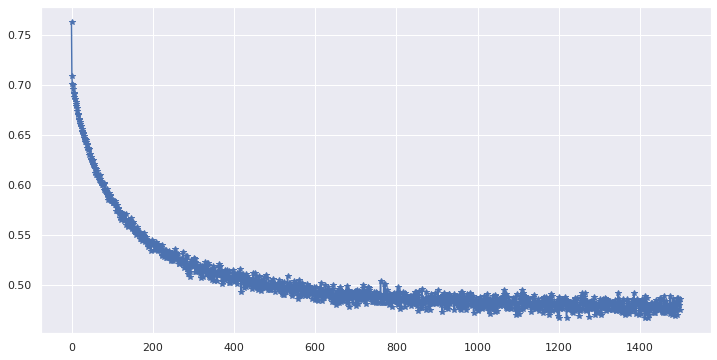

train Accuracy: 0.8062; test Accuracy: 0.8136
True Positives:4686	False Positives:1227
False Negatives:575	True Negatives:3178
Accuracy:0.8136
Recall:0.8907	Precision:0.7925
f1 measure:0.8387


In [83]:
regr = LogisticRegression(learning_rate=0.8,epochs=1500,batch_size=5000, l1_penalty = 0.008, l2_penalty = 0.00005)

regr.fit(X_train, y_train)

regr.plot_cost()

print( 'train Accuracy: %.4f; test Accuracy: %.4f' % (regr.score(X_train, y_train), regr.score(X_test, y_test)))

regr.classification_report(X_test, y_test)

Смотрим веса

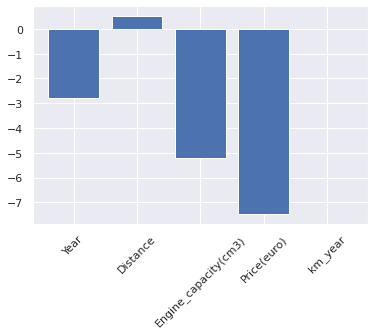

In [84]:
w, b = regr.get_w_and_b()
plt.bar(x = range(w.size),height=w)
plt.xticks(range(w.size),features_names, rotation = 45 );

# Предварительная обработка

Стандартизация

In [85]:
df_scaled = df.copy()
M = df[num_columns].mean()
STD = df[num_columns].std()
df_scaled[num_columns] = (df[num_columns]-M)/STD

df_scaled.head()

,Make,Model,Year,Style,Distance,Engine_capacity(cm3),Fuel_type,Transmission,Price(euro),Age,km_year,mileage
0,42,92,0.376492,4,0.128983,-0.112516,2,0,-0.179081,11,0.377953,1
1,34,62,0.793761,11,-0.490816,-0.604496,0,1,-0.095044,8,0.261792,1
2,34,71,0.515582,11,-0.749065,-0.604496,0,1,-0.305136,10,-0.538943,1
3,28,23,-0.318957,11,0.180633,-0.440503,3,1,-0.562500,16,-0.334500,1
4,23,126,-1.153495,5,1.213632,0.543457,0,1,-0.626578,22,-0.179619,1


Разбиваю на тренировочную и тестовую выборки

In [86]:
X1 = df_scaled[num_columns].values 
y1 = df_scaled["Transmission"].values 
features_names = df_scaled[num_columns].columns

X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.3, random_state=42)


scaler  = MinMaxScaler()
X1_train = scaler.fit_transform(X1_train)
X1_test  = scaler.transform(X1_test) 
pd.DataFrame(X1_train).tail()

,0,1,2,3,4
22549,0.40,0.011012,0.291667,0.006513,0.005179
22550,0.74,0.208921,0.270833,0.061112,0.297166
22551,0.84,0.155127,0.270833,0.078146,0.343601
22552,0.84,0.219922,0.229167,0.066132,0.487865
22553,0.94,0.049905,0.375000,0.251503,0.248497


Провожу логистическую регрессию

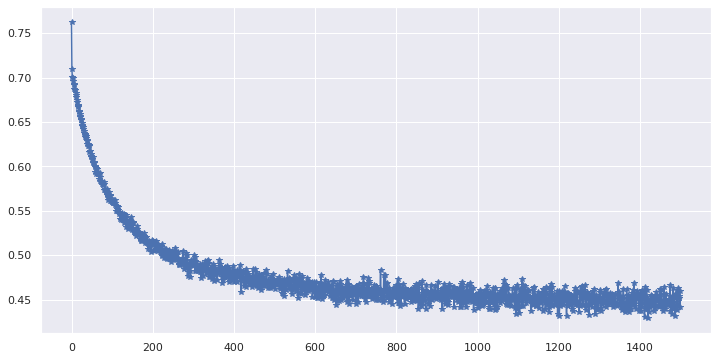

train Accuracy: 0.8066; test Accuracy: 0.8093
True Positives:4550	False Positives:1132
False Negatives:711	True Negatives:3273
Accuracy:0.8093
Recall:0.8649	Precision:0.8008
f1 measure:0.8316


In [87]:
regr = LogisticRegression(learning_rate=0.8,epochs=1500,batch_size=5000)

regr.fit(X1_train, y1_train)

regr.plot_cost()

print( 'train Accuracy: %.4f; test Accuracy: %.4f' % (regr.score(X1_train, y1_train), regr.score(X1_test, y1_test)))

regr.classification_report(X1_test, y1_test)

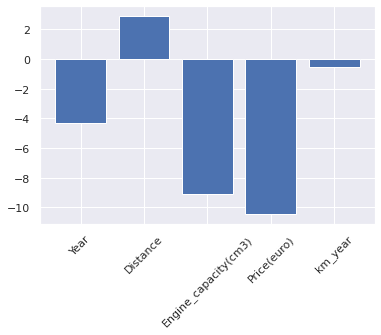

In [88]:
w, b = regr.get_w_and_b()
plt.bar(x = range(w.size),height=w)
plt.xticks(range(w.size),features_names, rotation = 45 );

Нормализация

In [89]:
df_norm  = df.copy()
Xmin = df[num_columns].min()
Xmax = df[num_columns].max()

df_norm[num_columns] = (df[num_columns]- Xmin)/( Xmax - Xmin)
df_norm.head()

,Make,Model,Year,Style,Distance,Engine_capacity(cm3),Fuel_type,Transmission,Price(euro),Age,km_year,mileage
0,42,92,0.80,4,0.194919,0.333333,2,0,0.075651,11,0.353252,1
1,34,62,0.86,11,0.134913,0.270833,0,1,0.083667,8,0.336172,1
2,34,71,0.82,11,0.109911,0.270833,0,1,0.063627,10,0.218437,1
3,28,23,0.70,11,0.199920,0.291667,3,1,0.039078,16,0.248497,1
4,23,126,0.58,5,0.299930,0.416667,0,1,0.032966,22,0.271270,1


In [90]:
X2 = df_norm[num_columns].values 
y2 = df_norm["Transmission"].values 
features_names = df_norm[num_columns].columns

X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.3, random_state=42)


scaler  = MinMaxScaler()
X2_train = scaler.fit_transform(X2_train)
X2_test  = scaler.transform(X2_test) 
pd.DataFrame(X2_train).tail()

,0,1,2,3,4
22549,0.40,0.011012,0.291667,0.006513,0.005179
22550,0.74,0.208921,0.270833,0.061112,0.297166
22551,0.84,0.155127,0.270833,0.078146,0.343601
22552,0.84,0.219922,0.229167,0.066132,0.487865
22553,0.94,0.049905,0.375000,0.251503,0.248497


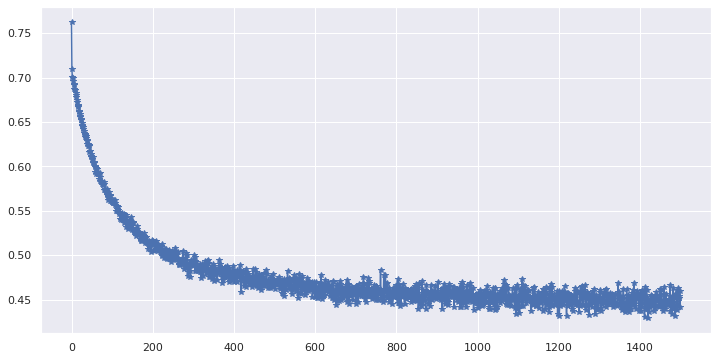

train Accuracy: 0.8066; test Accuracy: 0.8093
True Positives:4550	False Positives:1132
False Negatives:711	True Negatives:3273
Accuracy:0.8093
Recall:0.8649	Precision:0.8008
f1 measure:0.8316


In [91]:
regr = LogisticRegression(learning_rate=0.8,epochs=1500,batch_size=5000)

regr.fit(X2_train, y2_train)

regr.plot_cost()

print( 'train Accuracy: %.4f; test Accuracy: %.4f' % (regr.score(X2_train, y2_train), regr.score(X2_test, y2_test)))

regr.classification_report(X2_test, y2_test)

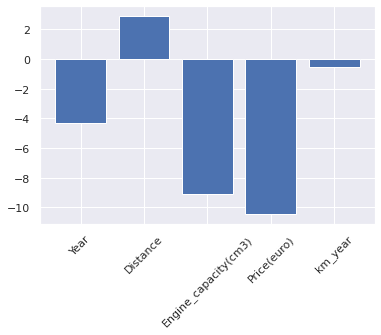

In [92]:
w, b = regr.get_w_and_b()
plt.bar(x = range(w.size),height=w)
plt.xticks(range(w.size),features_names, rotation = 45 );

Выводы

Судя по всему, предварительная обработка мало влияет на результат. Я даже заменяла названия переменных на X1, X2, же, но она всё равно выдаёт результаты почти неотличимые друг от друга.

# Добавление категориальных признаков

One-hot кодирование

In [93]:
df_dum = df.copy()
df_dum = pd.get_dummies(df_dum[cat_columns])
df_dum

,Make,Model,Style,Fuel_type,Transmission,mileage
0,42,92,4,2,0,1
1,34,62,11,0,1,1
2,34,71,11,0,1,1
3,28,23,11,3,1,1
4,23,126,5,0,1,1
...,...,...,...,...,...,...
32215,44,88,10,4,0,1
32216,19,53,3,3,1,1
32217,6,77,11,0,1,1
32218,22,10,1,0,1,1


Добавляю числовые признаки

In [94]:
num_columns

['Year', 'Distance', 'Engine_capacity(cm3)', 'Price(euro)', 'km_year']

In [95]:
df_dum['Year'] = df_norm['Year']
df_dum['Distance'] = df_norm['Distance']
df_dum['Engine_capacity(cm3)'] = df_norm['Engine_capacity(cm3)']
df_dum['Price(euro)'] = df_norm['Price(euro)']
df_dum['km_year'] = df_norm['km_year']
df_dum

,Make,Model,Style,Fuel_type,Transmission,mileage,Year,Distance,Engine_capacity(cm3),Price(euro),km_year
0,42,92,4,2,0,1,0.80,0.194919,0.333333,0.075651,0.353252
1,34,62,11,0,1,1,0.86,0.134913,0.270833,0.083667,0.336172
2,34,71,11,0,1,1,0.82,0.109911,0.270833,0.063627,0.218437
3,28,23,11,3,1,1,0.70,0.199920,0.291667,0.039078,0.248497
4,23,126,5,0,1,1,0.58,0.299930,0.416667,0.032966,0.271270
...,...,...,...,...,...,...,...,...,...,...,...
32215,44,88,10,4,0,1,0.90,0.087909,0.333333,0.113226,0.291917
32216,19,53,3,3,1,1,0.62,0.224922,0.333333,0.042084,0.223447
32217,6,77,11,0,1,1,0.88,0.088909,0.270833,0.068136,0.252791
32218,22,10,1,0,1,1,0.70,0.369937,0.375000,0.038076,0.461423


Разбиваю тестовую и тренировочную выборки

In [98]:
X,y = df_dum.drop(columns = ['Transmission']).values,df_dum['Transmission'].values
features_names = df_dum.drop(columns = ['Transmission']).columns

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


scaler  = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test) 
pd.DataFrame(X_train).tail()

,0,1,2,3,4,5,6,7,8,9
22549,0.977778,0.451852,0.363636,0.8,1.0,0.40,0.011012,0.291667,0.006513,0.005179
22550,0.933333,0.681481,0.909091,0.4,0.5,0.74,0.208921,0.270833,0.061112,0.297166
22551,0.133333,0.348148,0.272727,0.0,0.5,0.84,0.155127,0.270833,0.078146,0.343601
22552,0.288889,0.748148,0.363636,0.8,0.5,0.84,0.219922,0.229167,0.066132,0.487865
22553,0.822222,0.844444,0.909091,0.8,0.5,0.94,0.049905,0.375000,0.251503,0.248497


Провожу логистическую регрессию

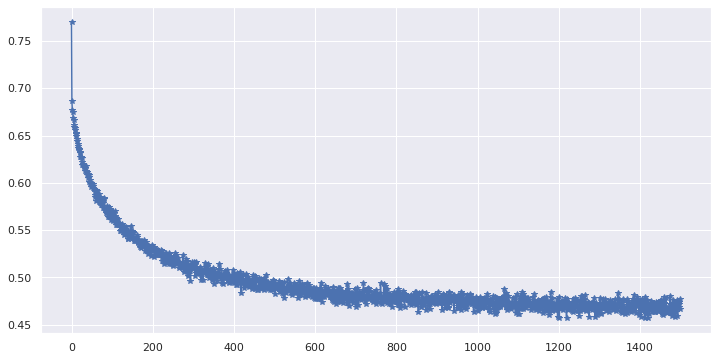

train Accuracy: 0.8168; test Accuracy: 0.8172
True Positives:4727	False Positives:1233
False Negatives:534	True Negatives:3172
Accuracy:0.8172
Recall:0.8985	Precision:0.7931
f1 measure:0.8425


In [99]:
regr = LogisticRegression(learning_rate=0.8,epochs=1500,batch_size=5000, l1_penalty = 0.008, l2_penalty = 0.00005)

regr.fit(X_train, y_train)

regr.plot_cost()

print( 'train Accuracy: %.4f; test Accuracy: %.4f' % (regr.score(X_train, y_train), regr.score(X_test, y_test)))

regr.classification_report(X_test, y_test)

Смотрим веса

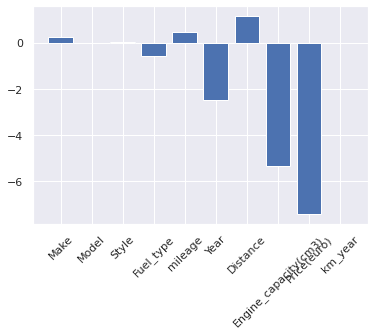

In [100]:
w, b = regr.get_w_and_b()
plt.bar(x = range(w.size),height=w)
plt.xticks(range(w.size),features_names, rotation = 45 );

# Анализ весов

Судя по графикам, которые не особенно меняются при разных типах предобработки и сохраняют те же тенденции при добавлении категориальных признаков, самыми значимыми для модели признаками являются Engine_capacity и Price. Видимо, машины с одним из типов передач часто имеют двигатели с бОльшим объёмом и продаются по более высокой цене.

Также надо отметить столбец Year, который тоже имеет довольно большой вес. Возможно, машины с одним из типов передач обычно новее.